In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import os
import numpy as np
import pandas as pd
import itertools

from keras import models
from keras import layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from shutil import copy2

from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

np.random.seed(123)


In [3]:
# # Set up data into train and test directories with folders of bobcat and not_bobcat
# train_data_dir = '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/train/'#348 bobcat, 340 not_bobcat
# test_data_dir = '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/test/'#348 bobcat, 340 not_bobcat

# test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         test_data_dir, 
#         target_size=(128, 128), batch_size=340)

# train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         train_data_dir, 
#         target_size=(128, 128), batch_size=340)

# # create the data sets
# train_images, train_labels = next(train_generator)
# test_images, test_labels = next(test_generator)

In [4]:
train_data_dir = '/Users/j.markdaniels/Desktop/Data/multiclass/train/'
test_data_dir = '/Users/j.markdaniels/Desktop/Data/multiclass/test/'

In [5]:
# get all the data in the directory split/test, and reshape them
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        '/Users/j.markdaniels/Desktop/Data/multiclass/test/', 
        target_size=(224, 224), 
        batch_size = 340, 
        seed = 123)

Found 2776 images belonging to 20 classes.


In [6]:
data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        '/Users/j.markdaniels/Desktop/Data/multiclass/train/', 
        target_size=(224, 224), 
        batch_size = 340, 
        seed = 123) 

Found 11179 images belonging to 20 classes.


In [7]:
#split images and labels
images_tr, labels_tr = next(data_tr)

/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 85 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 93 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 141 bytes but only got 0. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 149 bytes but only got 0. Skipping tag 37381
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [8]:
#split images and labels
images_te, labels_te = next(data_te)

In [9]:
images = np.concatenate((images_tr, images_te))

In [10]:
labels = np.concatenate((labels_tr[:,0], labels_te[:,0]))

In [11]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

In [13]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
new_model = models.Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
for i,layer in enumerate(imagenet.layers):
  print(i,layer.name, layer.trainable)

0 input_1 False
1 conv2d_1 True
2 batch_normalization_1 True
3 activation_1 True
4 conv2d_2 True
5 batch_normalization_2 True
6 activation_2 True
7 conv2d_3 True
8 batch_normalization_3 True
9 activation_3 True
10 max_pooling2d_1 True
11 conv2d_4 True
12 batch_normalization_4 True
13 activation_4 True
14 conv2d_5 True
15 batch_normalization_5 True
16 activation_5 True
17 max_pooling2d_2 True
18 conv2d_9 True
19 batch_normalization_9 True
20 activation_9 True
21 conv2d_7 True
22 conv2d_10 True
23 batch_normalization_7 True
24 batch_normalization_10 True
25 activation_7 True
26 activation_10 True
27 average_pooling2d_1 True
28 conv2d_6 True
29 conv2d_8 True
30 conv2d_11 True
31 conv2d_12 True
32 batch_normalization_6 True
33 batch_normalization_8 True
34 batch_normalization_11 True
35 batch_normalization_12 True
36 activation_6 True
37 activation_8 True
38 activation_11 True
39 activation_12 True
40 mixed0 True
41 conv2d_16 True
42 batch_normalization_16 True
43 activation_16 True
44 con

In [15]:
for i,layer in enumerate(new_model.layers):
  print(i,layer.name, layer.trainable)

0 inception_v3 True
1 global_average_pooling2d_1 True
2 dense_1 True
3 dense_2 True
4 dense_3 True
5 dense_4 True


In [16]:
for layer in new_model.layers[:1]:
    layer.trainable=False

In [17]:
for i,layer in enumerate(new_model.layers):
  print(i,layer.name, layer.trainable)

0 inception_v3 False
1 global_average_pooling2d_1 True
2 dense_1 True
3 dense_2 True
4 dense_3 True
5 dense_4 True


In [18]:
new_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
new_model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=50,
          validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 435 samples, validate on 109 samples
Epoch 1/10
435/435 [==============================] - 47s 109ms/step - loss: 0.3113 - acc: 0.9494 - val_loss: 0.2352 - val_acc: 0.9358
Epoch 2/10
435/435 [==============================] - 35s 80ms/step - loss: 0.0921 - acc: 0.9678 - val_loss: 0.0431 - val_acc: 0.9908
Epoch 3/10
435/435 [==============================] - 35s 80ms/step - loss: 0.0317 - acc: 0.9862 - val_loss: 0.1418 - val_acc: 0.9725
Epoch 4/10
435/435 [==============================] - 35s 80ms/step - loss: 0.0371 - acc: 0.9816 - val_loss: 0.1888 - val_acc: 0.9725
Epoch 5/10
435/435 [==============================] - 35s 80ms/step - loss: 0.0672 - acc: 0.9862 - val_loss: 0.0495 - val_acc: 0.9817
Epoch 6/10
435/435 [==============================] - 35s 80ms/step - loss: 0.0190 - acc: 0.9931 - val_loss: 0.1419 - val_acc: 0.9725
Epoch 7/10
435/435 [==============================] - 35s 79ms/step - loss: 0.0037 - acc: 0.9977 - va

In [19]:
new_model.evaluate(X_test, y_test)

136/136 [==============================] - 15s 111ms/step


[0.23705798681199125, 0.9852941176470589]

In [20]:
predictions_transfer = new_model.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[124   0]
 [  2  10]]


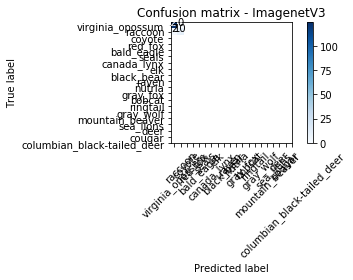

In [22]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer), classes=['virginia_opossum',
 'raccoon',
 'coyote',
 'red_fox',
 'bald_eagle',
 'seals',
 'canada_lynx',
 'elk',
 'black_bear',
 'raven',
 'nutria',
 'gray_fox',
 'bobcat',
 'ringtail',
 'gray_wolf',
 'mountain_beaver',
 'sea_lions',
 'deer',
 'cougar',
 'columbian_black-tailed_deer'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

## Jon's Confusion Matrix

In [28]:
labels = ['virginia_opossum','raccoon','coyote','red_fox','bald_eagle', 'seals', 'canada_lynx', 'elk', 'black_bear', 'raven', 'nutria', 'gray_fox', 'bobcat', 'ringtail', 'gray_wolf', 'mountain_beaver', 'sea_lions', 'deer', 'cougar', 'columbian_black-tailed_deer']
# Calculate Confusion Matrix
cm = confusion_matrix(all_test_actual, all_test_pred)

# Figure adjustment and heatmap plot
f = plt.figure(figsize=(20,30))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, vmax=100, cbar=False, cmap='Paired', mask=(cm==0), fmt=',.0f', linewidths=2, linecolor='grey', ); 

# labels
ax.set_xlabel('Predicted labels', fontsize=16);
ax.set_ylabel('True labels', labelpad=30, fontsize=16); 
ax.set_title('Confusion Matrix', fontsize=18); 
ax.xaxis.set_ticklabels(labels, rotation=90); 
ax.yaxis.set_ticklabels(labels, rotation=0);
ax.set_facecolor('white')
Collapse






NameError: name 'all_test_actual' is not defined

In [23]:
hist_new_model = new_model.history
loss_values = hist_new_model['loss']
val_loss_values = hist_new_model['val_loss']
acc_values = hist_new_model['acc'] 
val_acc_values = hist_new_model['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

In [24]:
results_train = new_model.evaluate(X_train, y_train)
results_test = new_model.evaluate(X_test, y_test)
print(results_train, results_test)

136/136 [==============================] - 15s 112ms/step
[0.0026334957740129896, 1.0] [0.23705798681199125, 0.9852941176470589]


In [25]:
predictions_transfer = new_model.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

In [26]:
f1_score(y_test, predictions_transfer)

0.9090909090909091

In [ ]:
#new_model.save('inception_draft.h5')